Convert Coco Dataset to Shards
==============================

This is a simple conversion of the MS Coco dataset to sharded tar files. It creates tar records for each image file, and then creates additional tar file entries for the annotations, captions, text, and person keypoints that are stored as additional files.

If you don't want to bother with this, you can also simply just tar up the images and then access the JSON files the same way you would with regular file-based I/O pipelines. However, it's generally just nicer and simpler to associate images and annotations directly, and with WebDataset representations as tar files, there is no cost to doing so.

In [1]:
%cd /mdata/coco-raw

/mdata/coco-raw


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import os.path
import random as pyr
import sys
import tarfile
import argparse
import re
import simplejson
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import matplotlib as mpl
import pprint
import tarfile
import time
import io
pp = pprint.PrettyPrinter(indent=4)
def jsp(x): print(simplejson.dumps(x, indent=4, sort_keys=True))
from IPython.display import display

# train2014

In [4]:
with open("annotations/instances_train2014.json") as stream:
    instances = simplejson.load(stream)
with open("annotations/captions_train2014.json") as stream:
    captions = simplejson.load(stream)
with open("annotations/COCO_Text.json") as stream:
    cocotext = simplejson.load(stream)
with open("annotations/person_keypoints_train2014.json") as stream:
    person = simplejson.load(stream)

In [5]:
all_images = {}
for x in instances["images"]:
    all_images[x["id"]] = dict(__key__=x["id"], info=x, image=x["file_name"], instances=None, captions=None, texts=None, persons=None)
def dappend(k, x):
    global all_images
    entry = all_images[x["image_id"]]
    if entry.get(k) is None: entry[k] = []
    entry[k].append(x)
for x in instances["annotations"]:
    dappend("instances", x)
for x in captions["annotations"]:
    dappend("captions", x)
for x in person["annotations"]:
    dappend("persons", x)
for _, x in cocotext["anns"].items():
    dappend("texts", x)

In [6]:
def stats(l): return (len(l), amin(l), median(l), mean(l), amax(l))

In [7]:
print(stats([len(x["instances"]) for x in all_images.values() if x["instances"] is not None]))
print(stats([len(x["captions"]) for x in all_images.values() if x["captions"] is not None]))
print(stats([len(x["persons"]) for x in all_images.values() if x["persons"] is not None]))
print(stats([len(x["texts"]) for x in all_images.values() if x["texts"] is not None]))

(82081, 1, 4.0, 7.369634872869483, 93)
(82783, 5, 5.0, 5.0023917954169335, 7)
(45174, 1, 2.0, 4.102271217957232, 20)
(26847, 1, 3.0, 5.433083770998622, 211)


In [8]:
if isinstance(all_images, dict):
    all_images = sorted(list(all_images.items()))
all_images = [x[1] for x in all_images]

In [9]:
for k, v in all_images[0].items():
    print("{:9s} {}".format(k, repr(v)[:60]))

__key__   9
info      {'license': 3, 'file_name': 'COCO_train2014_000000000009.jpg
image     'COCO_train2014_000000000009.jpg'
instances [{'segmentation': [[500.49, 473.53, 599.73, 419.6, 612.67, 3
captions  [{'image_id': 9, 'id': 661611, 'caption': 'Closeup of bins o
texts     None
persons   None


In [10]:
# read images directly
def myimread(fname, base="train2014"):
    with open(base+"/"+fname, "rb") as stream:
        return stream.read()
    
# functions for converting data structures to UTF-8 encoded JSON
def cvjson(data):
    return bytes(simplejson.dumps(data, indent=4), encoding="utf-8")

# the fields we pay attention to
names = {
    "info.json": "info",
    "jpg": "image",
    "persons.json": "persons",
    "instances.json": "instances",
    "texts.json": "texts",
    "captions.json": "captions"
}
names = {v:k for k,v in names.items()}

def convert_sample(sample, base="train2014"):
    # use the number as the key
    result = dict(__key__="%06d"%(sample["__key__"],))
    # store the image in JPEG format
    result["jpg"] = myimread(sample["image"], base=base)
    # add whatever meta data we have as separate JSON files
    for k in "persons instances texts captions".split():
        if k in sample and sample[k] is not None:
            result[names[k]] = cvjson(sample[k])
    return result

In [11]:
result = convert_sample(all_images[0])
for k, v in result.items():
    print("{:20s} {}".format(k, repr(v)[:60]))

__key__              '000009'
jpg                  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00
instances.json       b'[\n    {\n        "segmentation": [\n            [\n      
captions.json        b'[\n    {\n        "image_id": 9,\n        "id": 661611,\n 


In [12]:
# FOR TESTING THIS NOTEBOOK ONLY; COMMENT OUT FOR FULL CONVERSION
all_images = all_images[:12000]

In [13]:
!rm -rf coco-*.tar
from webdataset import writer
print(len(all_images))
tarf = writer.ShardWriter("_coco-%06d.tar", encoder=False, maxcount=5000, maxsize=3e9)
for sample in all_images:
    result = convert_sample(sample)
    tarf.write(result)
tarf.close()

12000
# writing _coco-000000.tar 0 0.0 GB 0
# writing _coco-000001.tar 5000 0.9 GB 5000
# writing _coco-000002.tar 5000 0.9 GB 10000


Coco Text
=========

Look at Coco Text Maps

dict_keys(['__key__', 'info', 'image', 'instances', 'captions', 'texts', 'persons'])


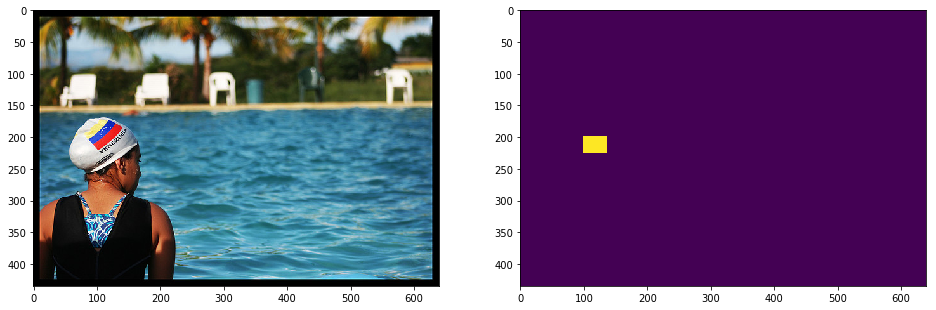

In [14]:
figsize(16,8)
l = list(all_images)
pyr.shuffle(l)
for v in l:
    k = v["__key__"]
    if v["texts"] is None: continue
    print(v.keys())
    image = imread("train2014/"+v["image"])
    h, w = image.shape[:2]
    textmap = zeros((h, w), 'f')
    for l in v["texts"]:
        x, y, w, h = [int(r) for r in l["bbox"]]
        textmap[y:y+h, x:x+w] = 1.0
    subplot(121); imshow(image)
    subplot(122); imshow(textmap)
    break

Write a dataset that contains only images with text annotations.

In [15]:
!rm -rf _cocotexts-*.tar
from webdataset import writer
print(len(all_images))
tarf = writer.ShardWriter("_cocotexts-%06d.tar", encoder=False, maxcount=5000, maxsize=3e9)
for sample in all_images:
    if "texts" not in sample: continue
    result = convert_sample(sample)
    tarf.write(result)
tarf.close()

12000
# writing _cocotexts-000000.tar 0 0.0 GB 0
# writing _cocotexts-000001.tar 5000 0.9 GB 5000
# writing _cocotexts-000002.tar 5000 0.9 GB 10000


# val2014

Now repeat the process for the validation set. (We might make this prettier by abstracting some of the functionality into more functions.)

In [16]:
with open("annotations/instances_val2014.json") as stream:
    instances = simplejson.load(stream)
with open("annotations/captions_val2014.json") as stream:
    captions = simplejson.load(stream)
with open("annotations/person_keypoints_val2014.json") as stream:
    person = simplejson.load(stream)

In [17]:
all_images = {}
for x in instances["images"]:
    all_images[x["id"]] = dict(__key__=x["id"], info=x, image=x["file_name"], instances=None, captions=None, texts=None, persons=None)
def dappend(k, x):
    global all_images
    entry = all_images[x["image_id"]]
    if entry.get(k) is None: entry[k] = []
    entry[k].append(x)
for x in instances["annotations"]:
    dappend("instances", x)
for x in captions["annotations"]:
    dappend("captions", x)
for x in person["annotations"]:
    dappend("persons", x)


In [18]:
print(stats([len(x["instances"]) for x in all_images.values() if x["instances"] is not None]))
print(stats([len(x["captions"]) for x in all_images.values() if x["captions"] is not None]))
print(stats([len(x["persons"]) for x in all_images.values() if x["persons"] is not None]))

(40137, 1, 4.0, 7.271968507860578, 70)
(40504, 5, 5.0, 5.003308315228126, 7)
(21634, 1, 2.0, 4.074743459369511, 16)


In [19]:
if isinstance(all_images, dict):
    all_images = sorted(list(all_images.items()))
all_images = [x[1] for x in all_images]

In [21]:
result = convert_sample(all_images[0], base="val2014")
for k, v in result.items():
    print("{:20s} {}".format(k, repr(v)[:60]))

__key__              '000042'
jpg                  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00
instances.json       b'[\n    {\n        "segmentation": [\n            [\n      
captions.json        b'[\n    {\n        "image_id": 42,\n        "id": 641613,\n


In [22]:
# FOR TESTING THIS NOTEBOOK ONLY; COMMENT OUT FOR FULL CONVERSION
all_images = all_images[:12000]

In [23]:
!rm -rf _coco-val-*.tar
from webdataset import writer
print(len(all_images))
tarf = writer.ShardWriter("_coco-val-%06d.tar", encoder=False, maxcount=5000, maxsize=3e9)
for sample in all_images:
    result = convert_sample(sample, base="val2014")
    tarf.write(result)
tarf.close()

12000
# writing _coco-val-000000.tar 0 0.0 GB 0
# writing _coco-val-000001.tar 5000 0.9 GB 5000
# writing _coco-val-000002.tar 5000 0.9 GB 10000
